## Transcriptome annotation on GCP

### Google Cloud Platform (GCP)

This notebook execute our workflow using the Google Cloud Life Sciences API. We explore different [machine types]( https://cloud.google.com/compute/docs/machine-types), first (N1) and second (N2) generation, and three number of CPUs for each machine type: 16, 32, and 64. We will call `configuration` to the combination of `MACHINE_TYPE/CPU`

The input data, transcriptome in FASTA file, is partitioned in the [01 - Data Partitioning.ipynb]( 01%20-%20Data%20Partitioning.ipynb). 20 FASTA files are created for each query size and are uploaded to a GCP storage bucket with prefixes: `nopal_2000_` for input data and `nopal_results_2000_` for the results files (2000 is for the query size processed and will be 2000, 6000 and 10000).

This notebook will create an organizational structure for storing the pipeline and logs files. It includes directories following the convention: `QUERY_SIZE/MACHINE_TYPE/CPU`. In addition, each `QUERY_SIZE` folder includes a `fasta` directory to store the FASTA files to be analyzed. See next directory tree for more information:

```bash
$ tree -dt ./results/PRJNA320545/
    ./results/PRJNA320545/
    ├── 10000
    │   ├── n1
    │   │   ├── 64
    │   │   ├── 32
    │   │   └── 16
    │   ├── n2
    │   │   ├── 64
    │   │   ├── 32
    │   │   └── 16
    │   └── fasta
    ├── 6000
    │   ├── n1
    │   │   ├── 64
    │   │   ├── 32
    │   │   └── 16
    │   ├── n2
    │   │   ├── 64
    │   │   ├── 32
    │   │   └── 16
    │   └── fasta
    └── 2000
        ├── n1
        │   ├── 64
        │   ├── 32
        │   └── 16
        ├── n2
        │   ├── 64
        │   ├── 32
        │   └── 16
        └── fasta

    30 directories
```

After completation, each configuration, `QUERY_SIZE/MACHINE_TYPE/CPU`, will include 22 files: 

* ` pipeline.json`: pipeline executed for that configuration.
* ` operations.tsv`: TSV file for relating FASTA file name with GCP operation ID and status
* `[1-20].json.gz`: Compressed GCP pipeline log for each operation.

```bash
    └── 2000
        └── n1
            └── 16
                ├── 10.json.gz
                ├── 11.json.gz
                ├── 12.json.gz
                ├── 13.json.gz
                ├── 14.json.gz
                ├── 15.json.gz
                ├── 16.json.gz
                ├── 17.json.gz
                ├── 18.json.gz
                ├── 19.json.gz
                ├── 1.json.gz
                ├── 20.json.gz
                ├── 2.json.gz
                ├── 3.json.gz
                ├── 4.json.gz
                ├── 5.json.gz
                ├── 6.json.gz
                ├── 7.json.gz
                ├── 8.json.gz
                ├── 9.json.gz
                ├── operations.tsv
                └── pipeline.json
```

The annotation files, output from the CWL workflow will be stored in the result bucket with prefix: `nopal_results_2000_`, each QUERY_SIZE bucket will include directories with name: `SAMPLE_MACHINE_TYPE_CPUs`, e.g. `2000_1_n1_16`, FASTA file `2000_1` output for machine type `n1` with `16` CPUs. 

### Requirements

#### [Cloud SDK](https://cloud.google.com/sdk)

Install the Cloud SDK in your local computer:

Enter the following at a command prompt:

 `$ curl https://sdk.cloud.google.com | bash`
 
Restart your shell: 

 `$ exec -l $SHELL`
 
Run *gcloud init* to initialize the gcloud environment:

 `$ gcloud init`
 




### Loading packages from config/init.py

In [1]:
%run ../config/init.py

### Testing gcloud configuration

In [2]:
account = !gcloud config get-value account
account = ''.join(account)
project = !gcloud config get-value project
project = ''.join(project)
if account and project:
    print('Using account: {} with project: {}'.format(account, project))
else:
    print('Please, configure Cloud SDK before running this notebook')
    print('Open a Terminal and run: gloud init')

Using account: veraalva@ncbi.nih.gov with project: cbb-research-dl


### Defining variables

Edit GCP zone and region variable accordingly to your geographical location.

In [3]:
ZONE = 'us-east1'
REGION = 'us-east1-c'

In [4]:
QUERY_SIZES = [2000, 6000, 10000]

MACHINE_TYPES = ['n1', 'n2']
CPUs = [16, 32, 64]

# Prices from 03/04/2020
PRICE = {
    'n1':{
        16: 0.861,
        32: 1.393,
        64: 2.475
    },
    'n2':{
        16: 0.951,
        32: 1.572,
        64: 2.816
    }    
}

PIPELINE_JSON = os.path.join(CONFIG, 'gcp', 'pipeline.json')
with open(PIPELINE_JSON) as fin:
    pipeline = json.load(fin)
    pipeline['resources']['zones'][0] = REGION

In [5]:
result_dir = os.path.join(RESULTS, DATASET)
if not os.path.exists(result_dir):
    os.mkdir(result_dir) 
os.chdir(result_dir)
print('Using as output directory: {}'.format(result_dir))

Using as output directory: /panfs/pan1.be-md.ncbi.nlm.nih.gov/alt_splicing/cloud-transcriptome-annotation/results/PRJNA320545


### Create or retrieve GCP storage bucket

In [6]:
bucket_list = !gsutil ls
buckets = {}
for q in QUERY_SIZES:
    prefix = 'gs://nopal_' + str(q) + '_'
    suffix = None
    for l in bucket_list:
        if prefix in l:
            suffix = l.replace('gs://nopal_' + str(q) + '_','').replace('/','')
            break
    if suffix:
        buckets[q] = suffix    

for q in QUERY_SIZES:
    if q not in buckets:
        suffix = str(uuid.uuid4())
        inbucket = 'nopal_' + str(q) + '_' + suffix
        outbucket = 'nopal_results_' + str(q) + '_' + suffix
        buckets[q] = suffix 
        
        !gsutil mb -l {ZONE} gs://{inbucket}
        !gsutil mb -l {ZONE} gs://{outbucket}
        !gsutil -m -o 'GSUtil:parallel_composite_upload_threshold=150M' -o 'GSUtil:parallel_process_count=16' -o 'GSUtil:parallel_thread_count=16' cp -R {q}/fasta/*.fa gs://{inbucket}/ 
        
for q in buckets:
    print('Query size: {0}\n\tin-bucket: nopal_{0}_{1}\n\tout-bucket: nopal_results{0}_{1}'.format(q, buckets[q]))

Query size: 2000
	in-bucket: nopal_2000_9649437f-0677-4573-b567-de6a2cb40c83
	out-bucket: nopal_results2000_9649437f-0677-4573-b567-de6a2cb40c83
Query size: 6000
	in-bucket: nopal_6000_21d1d4de-9db3-42ee-b6cb-d7e2bd667a20
	out-bucket: nopal_results6000_21d1d4de-9db3-42ee-b6cb-d7e2bd667a20
Query size: 10000
	in-bucket: nopal_10000_55581824-6fd2-4b02-9527-c43230a115a2
	out-bucket: nopal_results10000_55581824-6fd2-4b02-9527-c43230a115a2


### Submitting jobs
After running this cell you should go to the [Google Cloud Console](https://console.cloud.google.com/compute) to visualize all running instances.

In [7]:
operations = {}
for q in QUERY_SIZES:
    operations[q] = {}
    q_dir = os.path.join(result_dir, str(q))
    
    for m in MACHINE_TYPES:
        operations[q][m] = {}
        m_dir = os.path.join(q_dir, str(m))
    
        inbucket = 'nopal_' + str(q) + '_' + buckets[q]
        outbucket = 'nopal_results_' + str(q) + '_' + buckets[q]

        if not os.path.exists(m_dir):
            os.mkdir(m_dir)
        os.chdir(m_dir)        
        
        for c in CPUs:
            operations[q][m][c] = {}
            c_dir = os.path.join(m_dir, str(c))
            if not os.path.exists(c_dir):
                os.mkdir(c_dir)
            os.chdir(c_dir)

            if os.path.exists('operations.tsv'):
                operations[q][m][c] = {'logs':{}}
                operations[q][m][c]['operations'] = pandas.read_csv('operations.tsv', sep='\t')
            else:        
                pipeline['resources']['virtualMachine']['machineType'] = '{}-standard-{}'.format(m,c)
                with open('pipeline.json', 'w') as f:
                    f.write(json.dumps(pipeline, indent=2))  

                d = []
                for i in range(1,21):
                    sample = '{}_{}'.format(q, i)
                    a = !gcloud beta lifesciences pipelines run --pipeline-file=pipeline.json --env-vars=N={m},CPUs={c},INBUCKET={inbucket},OUTBUCKET={outbucket},SAMPLE={sample}
                    if len(a) == 1 and a[0].startswith('Running'):
                        a = a[0].replace('].','').split('/')[5]
                        d.append([i, a, 'running'])
                    else:
                        d.append([i, None, a])
                operations[q][m][c] = {'logs':{}}
                operations[q][m][c]['operations'] = pandas.DataFrame(d, columns=['sample', 'id', 'status'])
                operations[q][m][c]['operations'].to_csv('operations.tsv', sep='\t', index=None)
            os.chdir(c_dir)
    
        os.chdir(m_dir)
    

### GCP log retrival for plotting
This cell will download the GCP logs for completed operations (jobs) creating the `[1-20].json` files for each configuration. 

You should executed it multiple times until all operations are completed. 

In [14]:
for q in QUERY_SIZES:
    boxdata_total = []
    boxdata_blast = []
    boxdata_creation = []
    q_dir = os.path.join(result_dir, str(q))
    print('Query size: {}'.format(q))
    for m in MACHINE_TYPES:
        m_dir = os.path.join(q_dir, str(m))
        os.chdir(m_dir)
        for c in CPUs:
            if c in operations[q][m]:
                c_dir = os.path.join(m_dir, str(c))
                os.chdir(c_dir)
                df = operations[q][m][c]['operations'].dropna()
                data = []
                print('\tMachine type: {}-standard-{}'.format(m,c))
                for i, r in df.iterrows():
                    id = r['id']
                    if os.path.exists('{}.json.gz'.format(r['sample'])):
                        with gzip.GzipFile('{}.json.gz'.format(r['sample']), 'r') as fin:  
                            operations[q][m][c]['logs'][r['sample']] = json.loads(fin.read().decode('utf-8'))
                    else:
                        if r['sample'] not in operations[q][m][c]['logs']:
                            a = !gcloud beta lifesciences operations describe --format=json {id}
                            l = json.loads(''.join(a))
                            if 'done' in l:
                                operations[q][m][c]['logs'][r['sample']] = l
                                with gzip.GzipFile('{}.json.gz'.format(r['sample']), 'w') as fout:   # 4. gzip
                                    fout.write(json.dumps(l, indent=2).encode('utf-8'))  
                    if r['sample'] in operations[q][m][c]['logs']:
                        d = parse_gcp_json(operations[q][m][c]['logs'][r['sample']], r['sample'])
                        if d:
                            data.append(d)
                operations[q][m][c]['gcp'] = pandas.DataFrame(data, columns=['id', 'GCP', 'BlastDB', 'CWL'])
                platform = 'GCP\n{}\n{}'.format(m.upper(), c)
                for i, r in operations[q][m][c]['gcp'].iterrows():
                    boxdata_total.append([r['GCP']/pandas.Timedelta('1 minute'), platform])
                    boxdata_blast.append([r['BlastDB']/pandas.Timedelta('1 minute'), platform])
                    boxdata_creation.append([r['GCP']/pandas.Timedelta('1 minute') - (r['CWL']/pandas.Timedelta('1 minute') + r['BlastDB']/pandas.Timedelta('1 minute')), platform])
                os.chdir(c_dir)    
        os.chdir(m_dir)
    os.chdir(q_dir)
    operations[q]['total'] = pandas.DataFrame(boxdata_total, columns=['Time', 'Platform'])
    operations[q]['total'].to_csv('gcp_total.tsv', sep='\t', index=None)
    operations[q]['blast'] = pandas.DataFrame(boxdata_blast, columns=['Time', 'Platform'])
    operations[q]['blast'].to_csv('gcp_blast.tsv', sep='\t', index=None)
    operations[q]['creation'] = pandas.DataFrame(boxdata_creation, columns=['Time', 'Platform'])
    operations[q]['creation'].to_csv('gcp_creation.tsv', sep='\t', index=None)
    

Query size: 2000
	Machine type: n1-standard-16
	Machine type: n1-standard-32
	Machine type: n1-standard-64
	Machine type: n2-standard-16
	Machine type: n2-standard-32
	Machine type: n2-standard-64
Query size: 6000
	Machine type: n1-standard-16
	Machine type: n1-standard-32
	Machine type: n1-standard-64
	Machine type: n2-standard-16
	Machine type: n2-standard-32
	Machine type: n2-standard-64
Query size: 10000
	Machine type: n1-standard-16
	Machine type: n1-standard-32
	Machine type: n1-standard-64
	Machine type: n2-standard-16
	Machine type: n2-standard-32
	Machine type: n2-standard-64


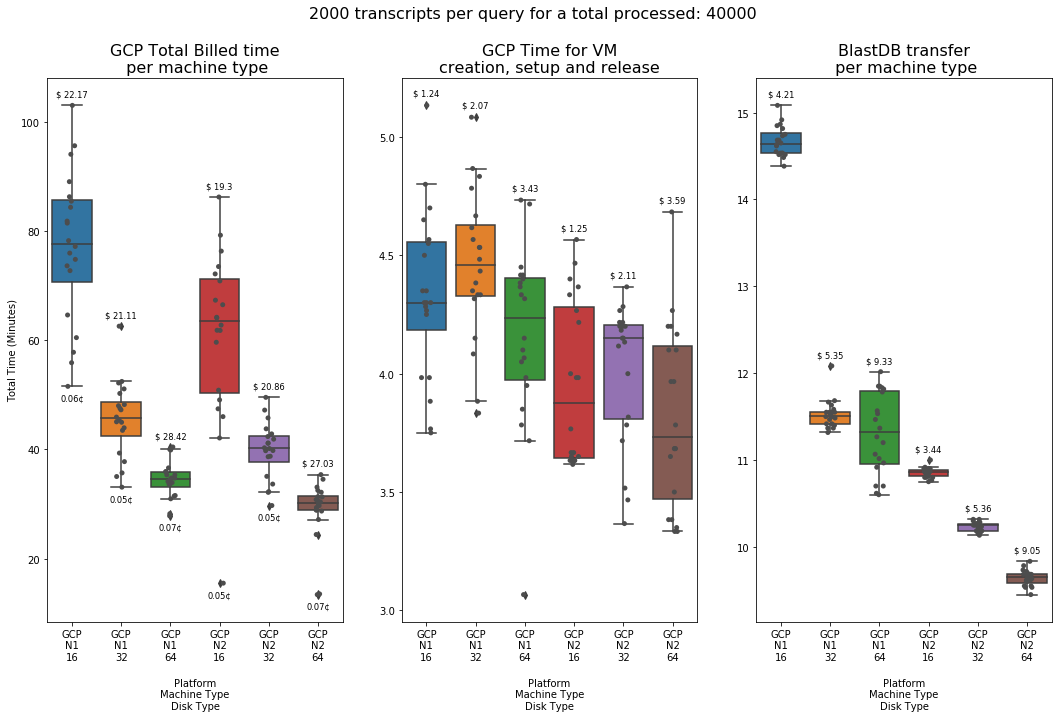

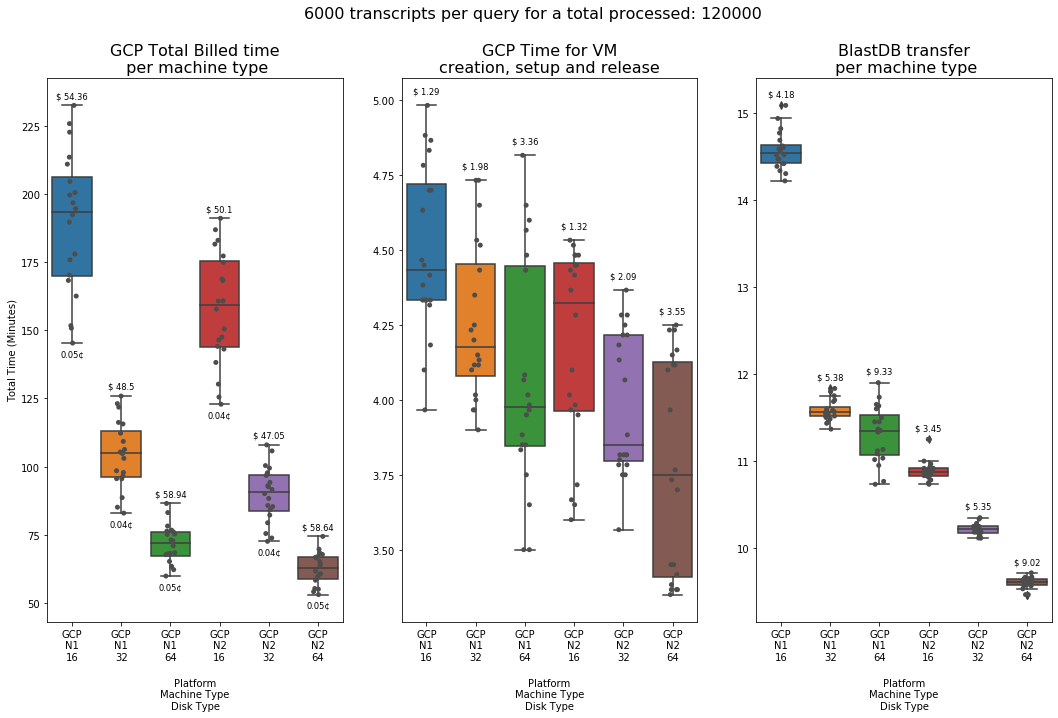

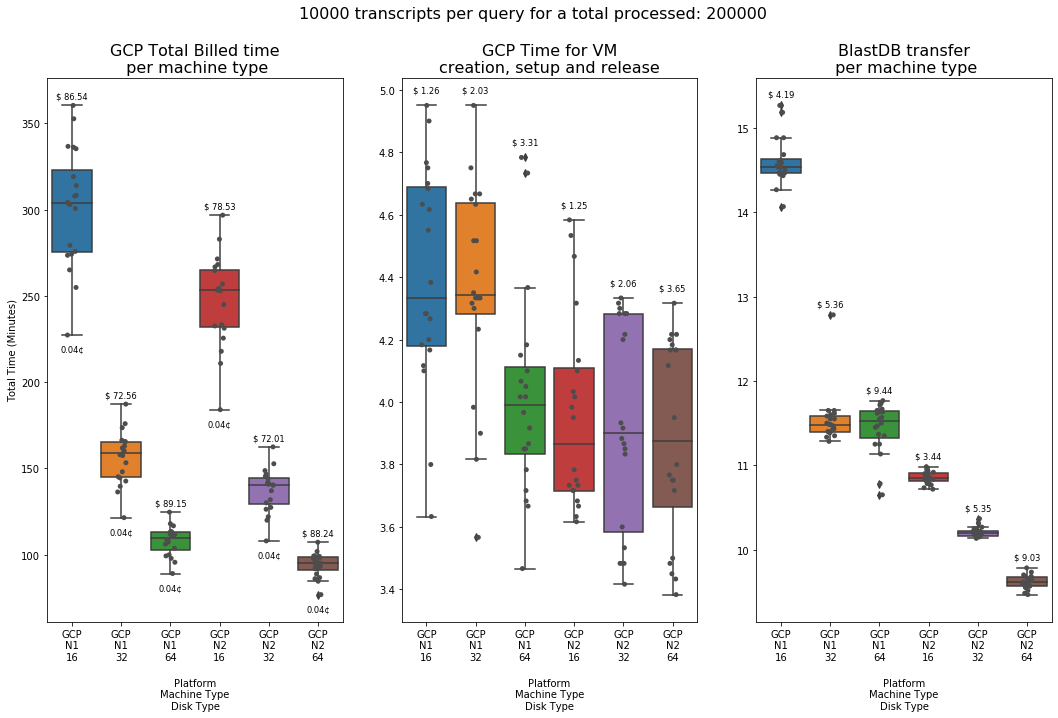

In [13]:
for q in QUERY_SIZES:
    df_total = operations[q]['total']
    df_blast = operations[q]['blast']
    df_creation = operations[q]['creation']

    fig, axs = plt.subplots(figsize=(18,10), ncols=3)

    fig.suptitle(locale.format_string("%d", int(q), grouping=True)
                         + ' transcripts per query for a total processed: ' 
                         + locale.format_string("%d", int(q) * 20, grouping=True)
                 + '\n\n', fontsize=16)

    j=0

    top = []
    low = []
    billed = []
    cost = []
    for p in df_total['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_total[df_total['Platform'] == p]['Time'].max())
        low.append(df_total[df_total['Platform'] == p]['Time'].min())
        billed.append('$ {}'.format(round(df_total[df_total['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        cost.append('{:.2f}¢'.format(df_total[df_total['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])] * 100/(int(q) * 20)))


    box_plot = sns.boxplot(x="Platform", y="Time", data=df_total, ax=axs[j])
    
    top_tick = 1.6
    low_tick = 2.6
    if q == 6000:
        top_tick += 1.0
        low_tick += 2.4
    elif q == 10000:
        top_tick += 2.2
        low_tick += 7.2

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,low[xtick] - low_tick,cost[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_total, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("Total Time (Minutes)")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("GCP Total Billed time\n per machine type", fontsize=16)

    j = 1

    top = []
    billed = []
    for p in df_creation['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_creation[df_creation['Platform'] == p]['Time'].max())
        billed.append('$ {}'.format(round(df_creation[df_creation['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_creation, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.04,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_creation, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("GCP Time for VM\ncreation, setup and release", fontsize=16)

    j = 2

    top = []
    billed = []
    for p in df_blast['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_blast[df_blast['Platform'] == p]['Time'].max())
        billed.append('$ {}'.format(round(df_blast[df_blast['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_blast, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.1,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_blast, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("BlastDB transfer\n per machine type", fontsize=16)
